## Import Libraries

In [0]:
import torch
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os


## Loading and transforming dataset
Dataset downloaded from https://www.kaggle.com/alxmamaev/flowers-recognition/download


In [2]:
batch_size=64
data_dir='/content/drive/My Drive/flowers'
transform= transforms.Compose([transforms.RandomResizedCrop(224),
                               transforms.ToTensor()])
data=datasets.ImageFolder(data_dir,transform=transform)
train_split=int(len(data)*0.8)
test_split= len(data)-train_split
train_data,test_data=torch.utils.data.random_split(data, (train_split,test_split))
print(len(train_data))
print(len(test_data))
train_loader= torch.utils.data.DataLoader(train_data, shuffle=True, batch_size= batch_size)
test_loader= torch.utils.data.DataLoader(test_data, shuffle=False, batch_size= batch_size)
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

3458
865


## Visualising data

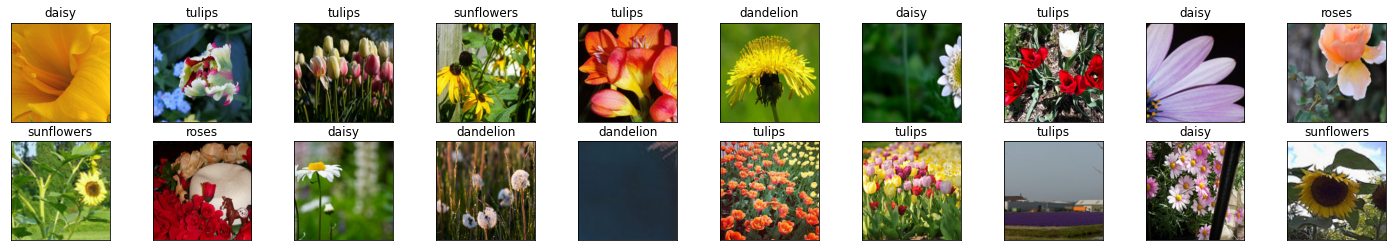

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Defining model

Downloading and freezing layers of VGG16 pre-trained model.

In [4]:
vgg16= models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
vgg16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [0]:
#Freezing parameters
for param in vgg16.parameters():
    param.requires_grad= False


In [7]:
#Replacing last fully connected layer
in_features= vgg16.classifier[6].in_features
out_features= 5
vgg16.classifier[6]= torch.nn.Linear(in_features, out_features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion= torch.nn.CrossEntropyLoss()

optimizer= torch.optim.SGD(vgg16.classifier.parameters(), lr=0.003)

## Training

In [9]:
train_on_gpu= torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


In [14]:
n_epochs= 10
if train_on_gpu:
    vgg16.cuda()
for epoch in range(n_epochs):
    train_loss=0
    for batch_i, (images,labels) in enumerate(train_loader):
        if train_on_gpu:
            images, labels= images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output=vgg16(images)
        loss= criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()*images.size(0)
    train_loss=train_loss/len(train_loader.dataset)
    print("Epoch: {} \tTraining loss: {:.6f}".format(epoch,train_loss))

Epoch: 0 	Training loss: 0.588136
Epoch: 1 	Training loss: 0.562374
Epoch: 2 	Training loss: 0.562604
Epoch: 3 	Training loss: 0.555235
Epoch: 4 	Training loss: 0.547102
Epoch: 5 	Training loss: 0.549634
Epoch: 6 	Training loss: 0.534699
Epoch: 7 	Training loss: 0.528982
Epoch: 8 	Training loss: 0.521917
Epoch: 9 	Training loss: 0.516082


In [11]:
print(train_loss)

0.6403541699043238


## Testing and visualizing results

In [15]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = vgg16(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(data.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.567740

Test Accuracy of daisy: 73% (101/137)
Test Accuracy of dandelion: 83% (186/222)
Test Accuracy of roses: 66% (99/150)
Test Accuracy of sunflowers: 83% (134/160)
Test Accuracy of tulips: 82% (162/196)

Test Accuracy (Overall): 78% (682/865)


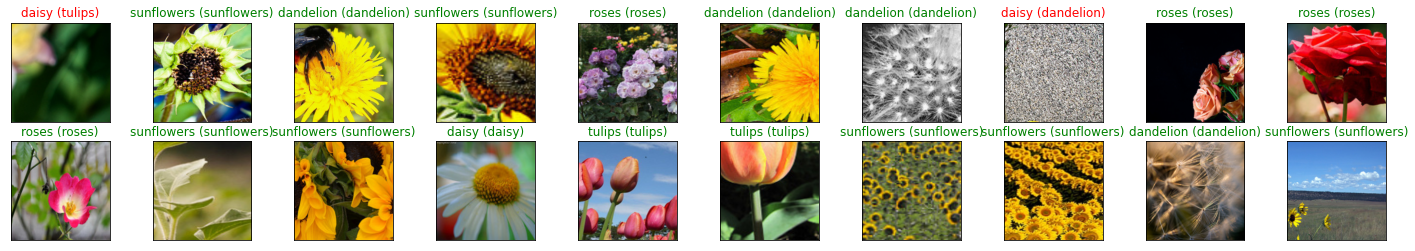

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()
if train_on_gpu:
    images = images.cuda()

output = vgg16(images)
_, preds_tensor = torch.max(output, 1)
images= images.cpu()
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))